In [8]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
from scipy import interpolate

In [9]:
alpha = 0.4

def P_0(eta):
    return np.max([eta, 1-eta])


def Prob(n,alpha,beta):
    p0 = np.exp(-(alpha+beta)**2)
    if n==0:
        return p0
    else:
        return 1-p0
    
def Prob_Outcome(n, alpha, beta, eta):
    q=0
    for a,et in zip([alpha, -alpha], [eta, 1-eta]):
       q+= et*Prob(n,a,beta)
    return q

def Postirior(n, alpha, beta, eta):
    po = Prob(n, alpha, beta)*eta
    po /= Prob_Outcome(n, alpha, beta, eta)
    return po

def P_1(beta, eta):
    p=0
    for n in [0,1]:
        p+= Prob_Outcome(n, alpha, beta,eta)*P_0(Postirior(n, alpha, beta,eta))
    return 1-p

def P_n(beta, eta,  model, at=1):
    p=0
    for n in [0,1]:
        p+=Prob_Outcome(n, at*alpha, beta, eta)*model(Postirior(n, at*alpha, beta, eta))
    return p

In [19]:
etas_min = np.linspace(0,.5,500)
whole_etas = np.concatenate([etas_min, (1-etas_min)[::-1]])

L=4
PS = np.zeros((L,2*len(etas_min)))
BOPT = np.zeros((L,2*len(etas_min)))

sm = lambda el: 0.01 if el != L-2 else 0.1
ep = lambda el: 1e-12 if el > 10 else 1e-10

for el in range(L)[::-1]:
    if el==L-1:
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            if ind_eta == 0:
                PS[el, ind_eta] = 0
                BOPT[el,ind_eta]= alpha
            else:
                optimization = optimize.minimize(P_1, BOPT[el, ind_eta-1], args=(eta), method="BFGS") #args=(eta), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
                PS[el,ind_eta]=optimization.fun
                BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]

    else:
        model = interpolate.Rbf(whole_etas, PS[el+1], smooth=0.01, epsilon=1e-2)
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            
            if ind_eta == 0:
                PS[el, ind_eta] = 0
                BOPT[el,ind_eta]= alpha
            else:
                optimization = optimize.minimize(P_n, BOPT[el, ind_eta-1], args=(eta, model, 1/np.sqrt(L)), method="BFGS") #args=(eta), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
                PS[el,ind_eta]=optimization.fun
                BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]


100%|██████████| 500/500 [00:01<00:00, 304.36it/s]


/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


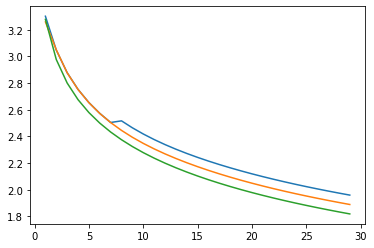

In [31]:
for k in PS[1:]:
    plt.plot(-np.log10(k[:30]),'-')

In [32]:
model = interpolate.Rbf(whole_etas, PS[2], smooth=0.01, epsilon=1e-2)

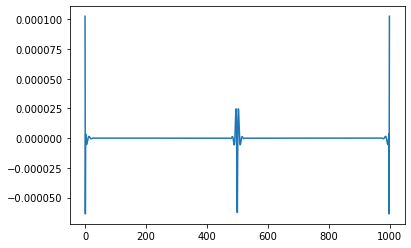

In [37]:
plt.plot(np.array([model(e) for e in whole_etas]) - PS[2])

In [123]:
def give_bounds(eta, alpha):
    if alpha < 1:
        return [((-1.5,1.5))]
    else:
        return [((-1.5*alpha,1.5*alpha))]

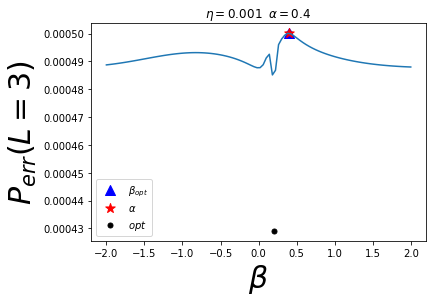

In [124]:
optimization = optimize.dual_annealing(P_n, x0=np.array([alpha]), args=(eta, model, 1/np.sqrt(L)), bounds=give_bounds(eta, alpha))

eta_ind=1
S=100
eta = etas_min[eta_ind]
betas = np.linspace(-2,2,100)
plt.plot(betas,[P_n(b , eta, model, 1/np.sqrt(L)) for b in betas])
plt.title(r'$\eta = $'+str(np.round(eta,4)) + r'$\; \;\alpha = $'+str(alpha))
plt.xlabel(r'$\beta$',size=30)
plt.ylabel(r'$P_{err}(L=3)$',size=30)
plt.scatter([BOPT[1, eta_ind]], [PS[1, eta_ind]])
b = BOPT[1, eta_ind]
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker="^", label=r'$\beta_{opt}$', color="blue", s=S )
b = alpha
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker='*', color="red", label=r'$\alpha$', s=S)

plt.scatter([optimization.x] , [optimization.fun], marker='.', color="black", label=r'$opt$', s=S)
plt.legend()

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: OptimizeWarning: Unknown solver options: tol
  """Entry point for launching an IPython kernel.


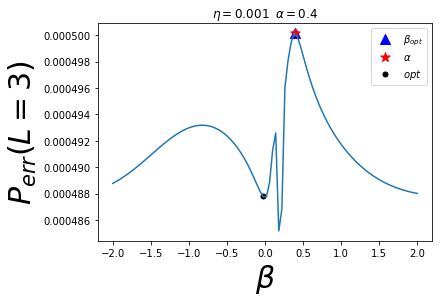

In [104]:
optimization = optimize.minimize(P_n, 0.25, args=(eta, model, 1/np.sqrt(L)), method="BFGS", options={"maxiter":1e5, "tol":1e-12})

eta_ind=1
S=100
eta = etas_min[eta_ind]
betas = np.linspace(-2,2,100)
plt.plot(betas,[P_n(b , eta, model, 1/np.sqrt(L)) for b in betas])
plt.title(r'$\eta = $'+str(np.round(eta,4)) + r'$\; \;\alpha = $'+str(alpha))
plt.xlabel(r'$\beta$',size=30)
plt.ylabel(r'$P_{err}(L=3)$',size=30)
plt.scatter([BOPT[1, eta_ind]], [PS[1, eta_ind]])
b = BOPT[1, eta_ind]
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker="^", label=r'$\beta_{opt}$', color="blue", s=S )
b = alpha
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker='*', color="red", label=r'$\alpha$', s=S)

plt.scatter([optimization.x] , [optimization.fun], marker='.', color="black", label=r'$opt$', s=S)

plt.legend()

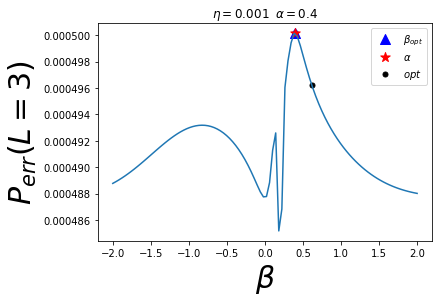

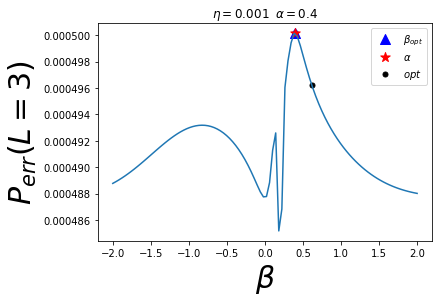

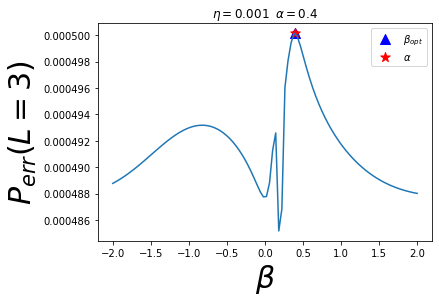

In [69]:
eta_ind=1
S=100
eta = etas_min[eta_ind]
betas = np.linspace(-2,2,100)
plt.plot(betas,[P_n(b , eta, model, 1/np.sqrt(L)) for b in betas])
plt.title(r'$\eta = $'+str(np.round(eta,4)) + r'$\; \;\alpha = $'+str(alpha))
plt.xlabel(r'$\beta$',size=30)
plt.ylabel(r'$P_{err}(L=3)$',size=30)
plt.scatter([BOPT[1, eta_ind]], [PS[1, eta_ind]])
b = BOPT[1, eta_ind]
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker="^", label=r'$\beta_{opt}$', color="blue", s=S )

b = alpha
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker='*', color="red", label=r'$\alpha$', s=S)
plt.legend()

In [ ]:
eta_ind=1
S=100
eta = etas_min[eta_ind]
betas = np.linspace(-2,2,100)
plt.plot(betas,[P_n(b , eta, model, 1/np.sqrt(L)) for b in betas])
plt.title(r'$\eta = $'+str(np.round(eta,4)) + r'$\; \;\alpha = $'+str(alpha))
plt.xlabel(r'$\beta$',size=30)
plt.ylabel(r'$P_{err}(L=3)$',size=30)
plt.scatter([BOPT[1, eta_ind]], [PS[1, eta_ind]])
b = BOPT[1, eta_ind]
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker="^", label=r'$\beta_{opt}$', color="blue", s=S )

b = alpha
plt.scatter([b] , [P_n(b , eta, model, 1/np.sqrt(L))], marker='*', color="red", label=r'$\alpha$', s=S)
plt.legend()

In [10]:
etas_min = np.linspace(0,.5,500)
whole_etas = np.concatenate([etas_min, (1-etas_min)[::-1]])

L=4
PS = np.zeros((L,2*len(etas_min)))
BOPT = np.zeros((L,2*len(etas_min)))

sm = lambda el: 0.01 if el != L-2 else 0.1
ep = lambda el: 1e-12 if el > 10 else 1e-10

for el in range(L)[::-1]:
    if el==L-1:
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            if ind_eta == 0:
                PS[el, ind_eta] = .5
                BOPT[el,ind_eta]= alpha
            else:
                optimization = optimize.minimize(P_1, BOPT[el, ind_eta-1], args=(eta), method="BFGS") #args=(eta), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
                PS[el,ind_eta]=optimization.fun
                BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]

    else:
        model = interpolate.Rbf(whole_etas, PS[el+1], smooth=0.01, epsilon=1e-2)
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            
            if ind_eta == 0:
                PS[el, ind_eta] = .5
                BOPT[el,ind_eta]= alpha
            else:
                optimization = optimize.minimize(P_1, BOPT[el, ind_eta-1], args=(eta), method="BFGS") #args=(eta), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
                PS[el,ind_eta]=optimization.fun
                BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]


100%|██████████| 500/500 [00:03<00:00, 159.47it/s]


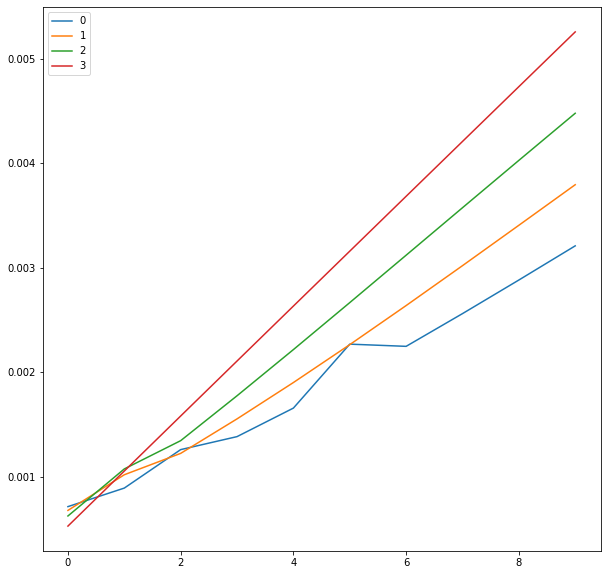

In [13]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    plt.plot(PS[k][:10],label=k)
plt.legend()

In [138]:
give_lim= lambda eta,a : ((-2,2)) if eta>0.01 else ((a-1e-5, a+1e-5))

etas_min = np.linspace(1e-10,.5,100)
whole_etas = np.concatenate([etas_min, (1-etas_min)[::-1]])


L=20
PS = np.zeros((L,2*len(etas_min)))
BOPT = np.zeros((L,2*len(etas_min)))

sm = lambda el: 1e-6 if el != L-2 else 0.01
for el in range(L)[::-1]:
    if el==L-1:
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_1, args=(eta), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]

    else:
        
        model = interpolate.Rbf(whole_etas, PS[el+1], smooth=sm(el), epsilon=1e-3)
        
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_n, args=(eta, model, 1/np.sqrt(L)), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]


100%|██████████| 100/100 [00:00<00:00, 258.05it/s]


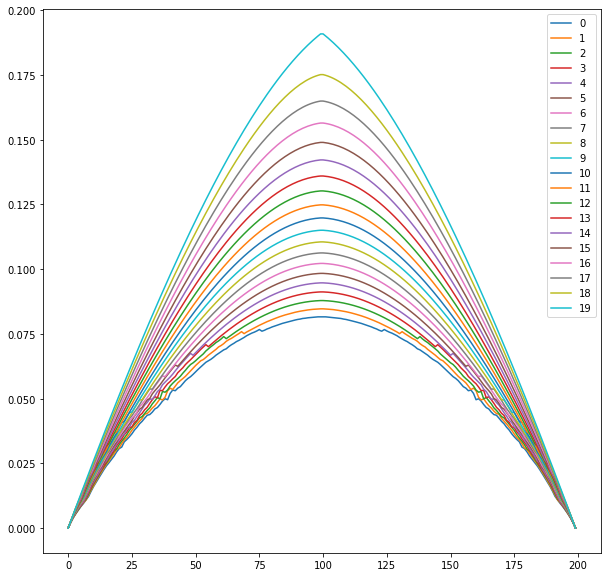

In [139]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    plt.plot(PS[k], label=k)
plt.legend()

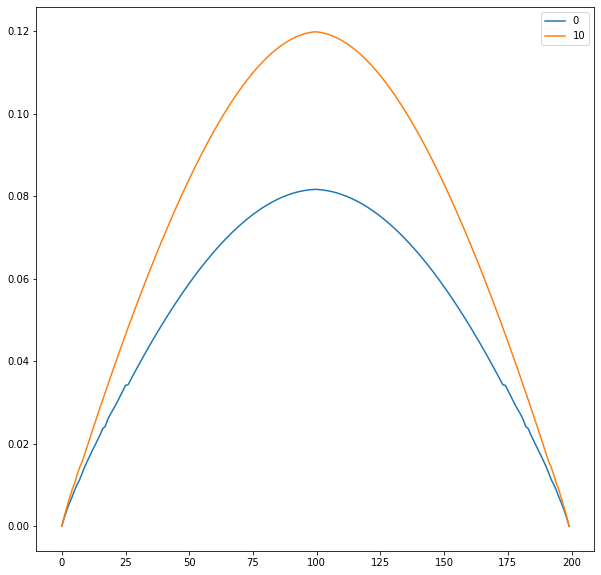

In [127]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    if k%10==0:
        plt.plot(PS[k], label=k)
plt.legend()

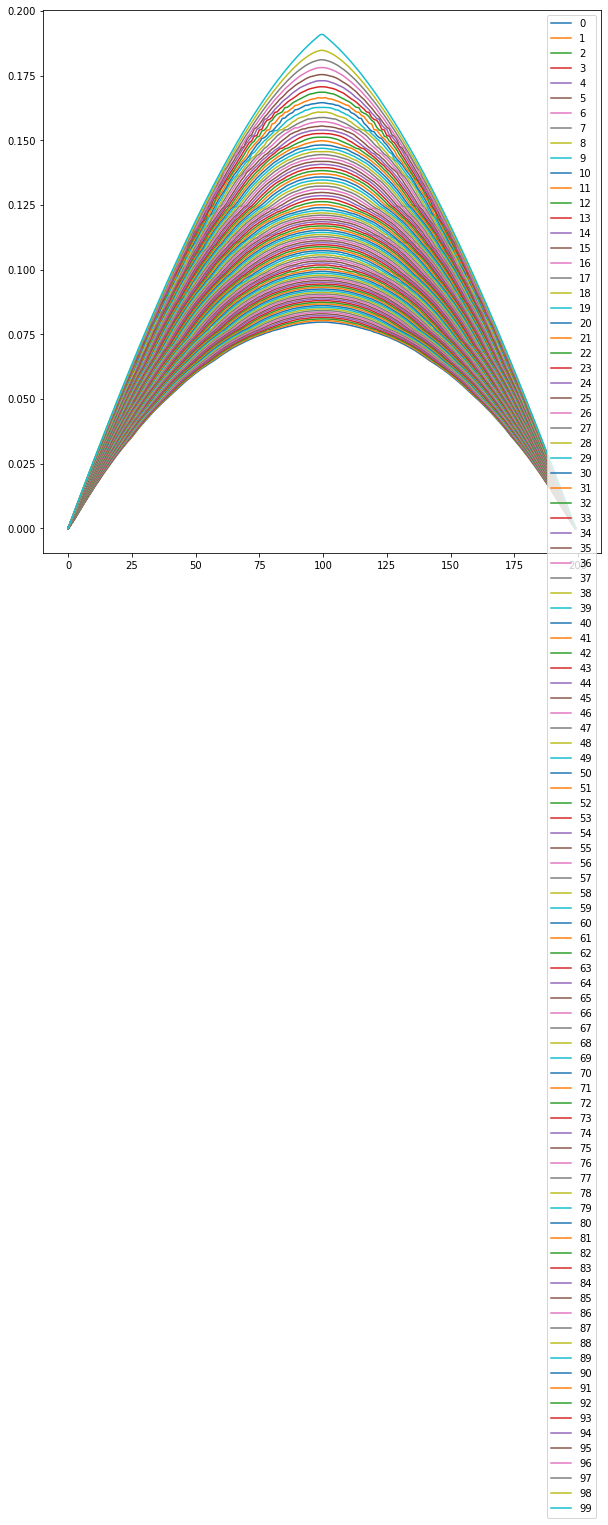

In [35]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    plt.plot(PS[k], label=k)
plt.legend()

In [394]:
give_lim= lambda eta,a : ((-2,2)) if eta>0.01 else ((a-1e-5, a+1e-5))

etas_min = np.linspace(1e-10,.5,100)
whole_etas = np.concatenate([etas_min, (1-etas_min)[::-1]])


L=10
PS = np.zeros((L,2*len(etas_min)))
BOPT = np.zeros((L,2*len(etas_min)))

for el in range(L)[::-1]:

    if el==L-1:

        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_1, args=(eta), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]

    else:
        model = interpolate.Rbf(whole_etas, PS[el+1], smooth=0.1,epsilon=1e-12)
        
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_n, args=(eta, model, 1/np.sqrt(L)), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]


100%|██████████| 100/100 [00:00<00:00, 258.72it/s]


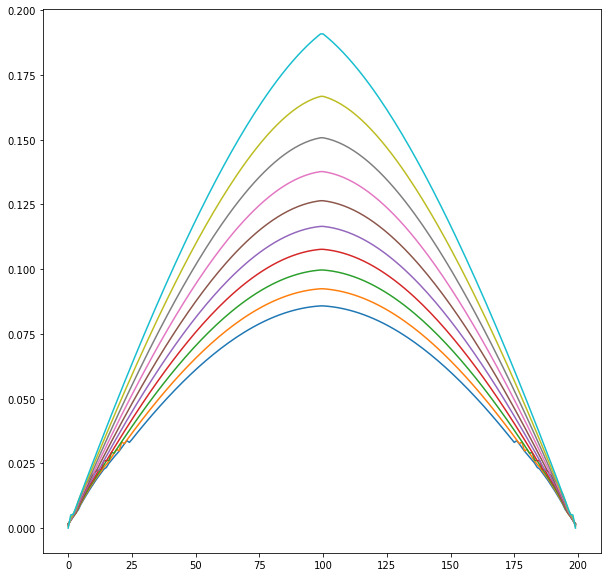

In [374]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    plt.plot(PS[k])

In [418]:
alpha=.05

def give_lim(eta,a):
    if eta<1e-2 or a > 1:
        l=1e-5
        return ((a-l, a+l))
    else:
        return ((-2,2))
    
etas_min = np.linspace(1e-5,.5,150)
whole_etas = np.concatenate([etas_min, (1-etas_min)[::-1]])


L=10
PS = np.zeros((L,2*len(etas_min)))
BOPT = np.zeros((L,2*len(etas_min)))

for el in range(L)[::-1]:

    if el==L-1:

        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_1, args=(eta), method="bounded", bounds = give_lim(eta,alpha))
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]

    else:

        model = interpolate.Rbf(whole_etas, PS[el+1], smooth=.1,ep=1e-12)
        
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_n, args=(eta, model, 1/np.sqrt(L)), method="bounded", bounds = give_lim(eta,alpha))
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]


100%|██████████| 150/150 [00:00<00:00, 240.64it/s]


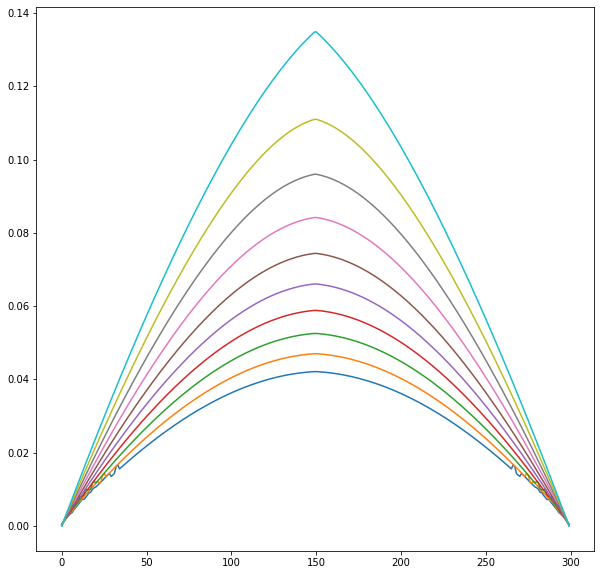

In [417]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    plt.plot(PS[k])

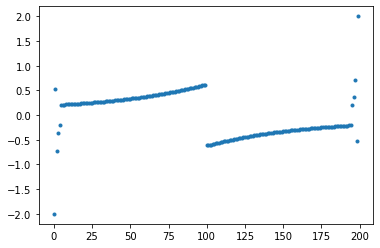

In [297]:
plt.plot(BOPT[0],'.')

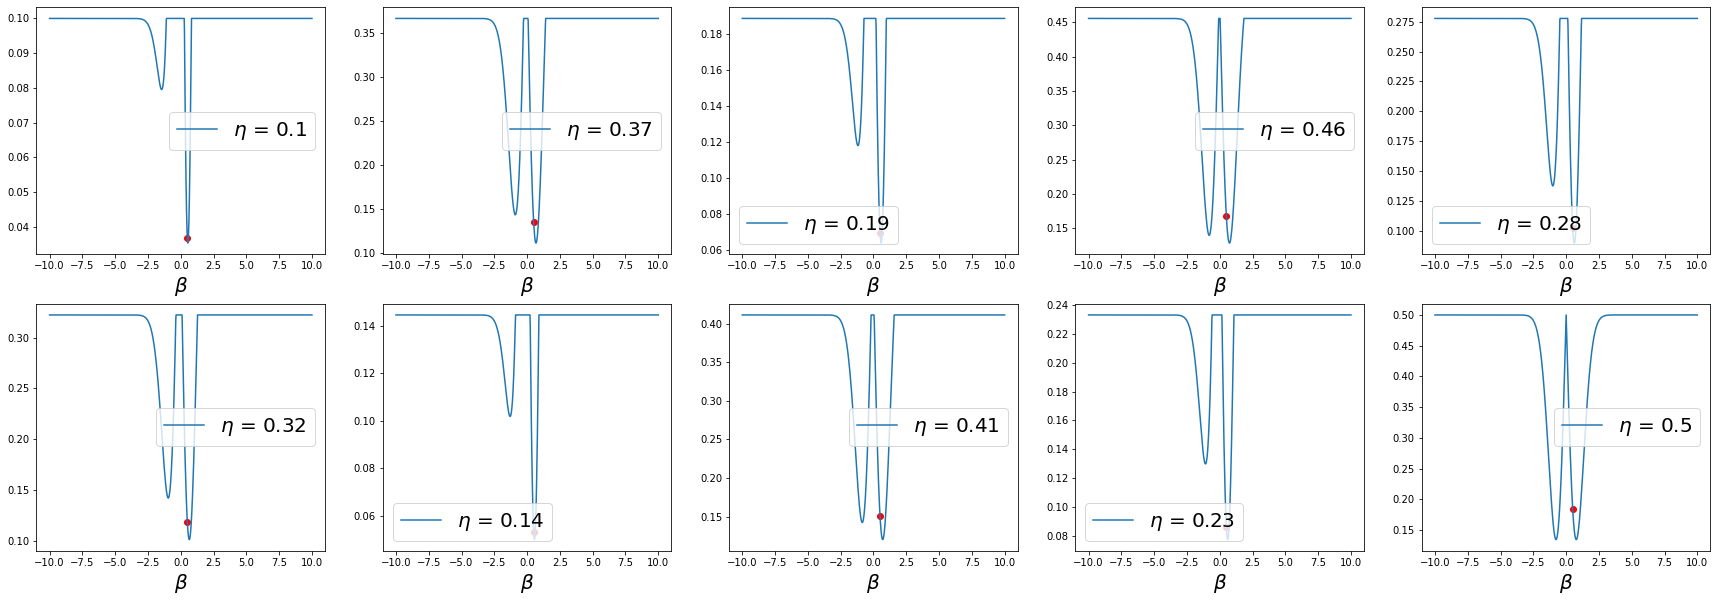

In [246]:
alpha=.5
plt.figure(figsize=(30,10))
betas = np.linspace(-10,10,1001)
for ind,et in enumerate(np.linspace(.1,.5,10)):##enumerate(np.logspace(-5,0,10)):
    ax = plt.subplot2grid((2,5),(ind%2, ind%5))
    ax.plot(betas, [P_1(b,et) for b in betas], label=r'$\eta$ = '+str(np.round(et,2)))
    ax.scatter([alpha], [P_1(alpha,et)], color="red")#, label=r'$\eta$ = '+str(np.round(et,2)))
    ax.set_xlabel(r'$\beta$',size=20)
    ax.legend(prop={"size":20})